# MFML - Final Project

### Feature importance via wavelet decomposition of RF - Reproduce the feature importance results of [1]

1. Provide summary of the wavelet-based method with emphasis on the use of the validation set to
determine a threshold for wavelet norms.
1. Test on regression & classification problems (multi-class problems).
1. Compare extensively with standard methods as in [1]. 

#### We will use the following data sets:

   - Classification
       - [Human Activity Recognition Using Smartphones Data Set](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)
   - Regression
       - [Abalone Data Set](https://archive.ics.uci.edu/ml/datasets/Abalone)       


#### We compare the following methods for VI

   - Gain via RF
   - Gain via XGBoost
   - SHAP over RF
   - SHAP over XGBoost
   - Permutation
   - WV-RF-based VI
   
#### Links

   - [Shap](https://github.com/slundberg/shap)
   - [Skater - for permutation-based VI](https://github.com/datascienceinc/Skater)
   
## Methodology

   - We first find the order of variables (by importance) using the different VI methods.
   - Next, we compare the ordering using CV and a single (joint) classifier/regressor.
   
   
## Navigation

1. [Q1](#Q1) 
1. [Q2+Q3](#Q3)
   - [Classification](#Classification---Human-Activity-Recognition-Using-Smartphones-Data)
       - [Description](#Description)
       - [Load Data](#Load-Data)
       - [EDA](#EDA)
       - [VI Ordering](#VI-Ordering)
       - [Compare Orderings](#Compare-Orderings)
   - [Regression](#Regression---Abalone-Age-Prediction)
       - [What's an Abalone](#What's-an-Abalone)
       
## References
    
[[1]](http://www.jmlr.org/papers/volume17/15-203/15-203.pdf)  O. Elisha and S. Dekel, Wavelet decompositions of Random Forests - smoothness analysis, sparse
approximation and applications, JMLR 17 (2016). 

In [19]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [20]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder

# models
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm

# shap
import shap

# skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

# Vis.
from plotnine import *
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
%matplotlib inline

## Q1

[Top](#MFML---Final-Project)

### Wavelet Decomposition of Random Forest


[Top](#MFML---Final-Project)

Random Forest, first introduced by [Breiman](https://www.stat.berkeley.edu/~breiman/bagging.pdf) in 1996, is an ensemble algorithm based on decision trees, that is widely used for both regression and classification problems. 

For a better understanding of the Random Forest (RF) algorithm, we will start in the roots of the algorithm, the bagging. The bagging algorithm is a submethod of the bootstrap resmampling method, used for generating multiple versions of a predictor on different samples, in order to derive a better generalization of the model. This method usually works for unstable methods, with decision trees as the lead example. 

Consider a general regression problem: Denote a train set $T$ of samples $\left\{ x_{i},f\left(x_{i}\right)=y_{i}\right\} _{i=1}^{N}\in\left(\varOmega_{0}\in\mathbb{R}^{n},\mathbb{R}\right)$. Let $c_{\varOmega}=\frac{1}{\#\left\{ x_{i}\in\varOmega\right\} }\sum_{x_{i}\in\varOmega}f\left(x_{i}\right)$ on $\varOmega$, a subdomain of $\varOmega_{0}$.

We can consider a regression problem since it is easy to convert any multiclass classification problem to a regression in the following way: Denote a train set $T$ of samples $\left\{ x_{i},y_{i}\right\} _{i=1}^{N}$, where each $x_{i}\in\mathbb{R}^{n}$ is assigned through a function $f$ to a class $y_{i}=C\left(x_{i}\right)$.
This problem can be converted to numeric settings by assigining to each class value $C$ the value of a node on the regular simplex consisting of $L$ verticals in $\mathbb{R}^{L-1}$. Thus, our classification problem is now translated to a regression problem with train data $\left\{ x_{i},C\left(x_{i}\right)\right\} _{i=1}^{N}\in\left(\varOmega_{0}\in\mathbb{R}^{n},\mathbb{R}^{L-1}\right)$. In this case, $\vec{E}_{\varOmega}$ is the calculated mean over any subdomain, and in fact is a point inside the simplex. 


The RF algorithm is based on the following steps:

* Draw B bootstrap samples of the train data $T$ with replacement. This sample can be constructed as $0<P<100$ percents of the train sample. 
* For each sample $T_{j}$ for $j=1,\ldots,B$ fit a decision tree, where in each split use $m$ covariates only for the prediction
* The final prediction is derived by averaging the predictions on the B trees

The classic algorithm is based on Isotopic sub divisions in order to set the splits in each node in an efficent way. 
More formally, denote our current subdomain $\varOmega$ of the origin data $\varOmega_{0}$. The next split is defined by the following minimization probelm:


\begin{equation*}
\underset{\varOmega^{'}\cup\varOmega^{''}=\varOmega}{min}\sum_{x_{i}\in\varOmega^{'}}\left(f\left(x_{i}\right)-c_{\varOmega^{'}}\right)^{2}+\sum_{x_{i}\in\varOmega^{''}}\left(f\left(x_{i}\right)-c_{\varOmega^{''}}\right)^{2}
\end{equation*}

Then, [Elisha and Dekel](http://www.jmlr.org/papers/volume17/15-203/15-203.pdf) show that this minimization problem is equivalent to the maximization problem 

\begin{equation*}
\underset{\varOmega^{'}\cup\varOmega^{''}=\varOmega}{max}\left\Vert \psi_{\varOmega^{'}}\right\Vert _{2}^{2}+\left\Vert \psi_{\varOmega^{''}}\right\Vert _{2}^{2}
\end{equation*}

where $\psi_{\varOmega^{'}}$ is the geometric wavelet, defined as
\begin{equation*}
\psi_{\varOmega^{'}}=I_{\varOmega^{'}}\left(c_{\varOmega^{'}}-c_{\varOmega}\right)
\end{equation*}
and $\left\Vert \psi_{\varOmega^{'}}\right\Vert _{2}^{2}=\sum_{x_{i}\in\varOmega^{'}}\left\Vert c_{\varOmega^{'}}-c_{\varOmega}\right\Vert _{2}^{2}=\left\Vert c_{\varOmega^{'}}-c_{\varOmega}\right\Vert _{2}^{2}\#\left\{ x_{i}\in\varOmega^{'}\right\} $.

The wavalet representation of $f$ on a single tree $t$ is $f=\sum_{\varOmega\in t}\psi_{\varOmega}$. Thus, we can derive the wavelet representation of the entire RF of the function $f$ as a weighted combination of the representations of the trees
\begin{equation*}
\tilde{f}\left(x\right)=\sum_{j=1}^{B}\sum_{\varOmega\in t_{j}}\omega_{j}\psi_{\varOmega}\left(x\right)
\end{equation*}
For simplicity, assume $\omega_{j}=\frac{1}{B}$.

Now, we can derive a "pruned" representation of the ensemble using [Elisha and Dekel](http://www.jmlr.org/papers/volume17/15-203/15-203.pdf), by ordering the wavelts norms and considering only the most significant ones in the representation:
\begin{equation*}
\left\Vert \psi_{\varOmega_{k1}}\right\Vert _{2}\geq\left\Vert \psi_{\varOmega_{k2}}\right\Vert _{2}\geq\left\Vert \psi_{\varOmega_{k3}}\right\Vert _{2}\ldots
\end{equation*}
Unlike most of the pruning methods, this process is applied on the entire ensemble.

The final prediction is therefore $\hat{f}_{M}\left(x\right)=\frac{1}{B}\sum_{m=1}^{M}\psi_{k_{m}}\left(x\right)$.


The hyper-parameter $M$, which describes the number of wavelets in the final representation, is selected using a predefined validation data. More specifically, denote our train data $T$ and our validation data $V$, drawn from our original data. For each possible value of $M$, we derive the prediction of our model $\hat{f}_{M}\left(x\right)$ on each of the observations of our validation data. The chosen value of $M$ is the one that yields the minimal approximation error (for example, MSE) on the validation set. Generally, we would excpect that as we increase $M$, the error on the train data will decrease. However, the error on the validation data will decrease at first, but starting from a certain point, it may start to increase (i.e., we will start to overfit the train data). 


Finally, the feature importance of feature $i$ for $i=1,\ldots,n$ can be calculated as 
\begin{equation*}
s_{i}^{\tau}=\frac{1}{B}\sum_{j=1}^{B}\sum_{\varOmega\in t_{j}\land v_{i}}\left\Vert \psi_{\varOmega}\right\Vert _{2}^{\tau}
\end{equation*}
for $\tau>0$ and $v_{i}$ the set of child domains formed by partitioning their parent domain
along the $i^{th}$ variable

## Q2+Q3

[Top](#MFML---Final-Project)

### Auxilary Functions

In [21]:
def compute_vi(clf, X, y, features, k_fold):
    """
    Compute VI over all k folds.
    
    Parameters
    ----------
    clf: Classifier
    X: X matrix
    y: labels
    features: list of features
    k_fold: `sklearn.model_selection.KFold` object
    
    Returns
    -------
    pd.DataFrame with variables and importance score
    """
    vi_df = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(k_fold.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        fitted_clf = clf.fit(X_train, y_train)
        curr = pd.DataFrame({'imp':fitted_clf.feature_importances_,
                             'variable':features,
                             'fold':i})
        vi_df = vi_df.append(curr, ignore_index=True)
    return vi_df

In [22]:
def vi_score(clf, X, y, k_fold, model_name, 
             vi, ks, scoring = {'acc' : 'accuracy', 
                                'recall':lambda cls, X, y : 
                                                    recall_score(y, cls.predict(X), average = 'micro'), 
                                'precision':lambda cls, X, y : 
                                                    precision_score(y, cls.predict(X), average = 'micro')}):
    """
    Compute the scoring for a given model
    
    Parameters
    ----------
    clf: Classifier
    X: X matrix
    y: labels
    k_fold: `sklearn.model_selection.KFold` object
    model_name: Model name
    vi: Sorted list of varibles
    ks: list of k in [1, K] where K is the total number of features
    scoring: Scoring matrics to compute
    
    Returns
    -------
    pd.DataFrame with scoring for each fold and k in ks
    """
    score_df = pd.DataFrame()
    for k in ks:
        vars_list = vi[:k]
        curr_X = X[vars_list]
        curr_score_df = kfold_score(clf, curr_X, y, k_fold, model_name, scoring)
        curr_score_df['k'] = k
        score_df = score_df.append(curr_score_df, ignore_index = False)
        
    return score_df

In [23]:
def kfold_score(clf, X, y, k_fold, model_name, scoring):
    """
    Compute the scoring for a given model
    
    Parameters
    ----------
    clf: Classifier
    X: X matrix
    y: labels
    k_fold: `sklearn.model_selection.KFold` object
    model_name: Model name
    scoring: Scoring matrics to compute
    
    Returns
    -------
    pd.DataFrame with scoring for each fold
    """
    score = cross_validate(clf, X, y, 
                           cv = k_fold, scoring = scoring, 
                           return_train_score = False)
    score_df = pd.DataFrame(score)
    score_df['model'] = model_name
    
    return score_df

In [24]:
def compute_shap_vi(mod, X, y, features, k_fold, reg = False):
    """
    Compute SHAP-VI over all k folds.
    
    Parameters
    ----------
    mod: Classifier/Regressor
    X: X matrix
    y: labels
    features: list of features
    k_fold: `sklearn.model_selection.KFold` object
    reg: True if regression
    
    Returns
    -------
    pd.DataFrame with variables and importance score
    """
    vi_df = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(k_fold.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        fitted_mod = mod.fit(X_train, y_train)
        # shap vi
        explainer = shap.TreeExplainer(fitted_mod)
        shap_vals = explainer.shap_values(X_train)  
        if reg:
            mean_abs_shap = np.abs(shap_values).mean(0)
            sum_abs_shap = np.abs(shap_values).sum(0)
        else:   
            mean_abs_shap = np.array([np.abs(shap_vals[i]).mean(0) for i in range(len(shap_vals))]).mean(0)
            sum_abs_shap = np.array([np.abs(shap_vals[i]).mean(0) for i in range(len(shap_vals))]).sum(0)
        curr = pd.DataFrame({'imp_mean':mean_abs_shap,
                             'imp_sum':sum_abs_shap,
                             'variable':features,
                             'fold':i})
        vi_df = vi_df.append(curr, ignore_index=True)
    return vi_df

In [25]:
def compare_orderings(clf, 
                      model_order,
                      X, 
                      y,
                      k_fold,
                      scoring,
                      ks = range(1, 10)):
    """
    Parameters
    ----------
    model_order: 'vi_method_name':vi_order (string:list dict) 
    """
    vi_score_df = pd.DataFrame()
    for model, var_list in model_order.items():
        print("Calc. VI score for {}...".format(model))
        curr_score = vi_score(clf, 
                              X = X, y = y, 
                              k_fold = k_fold, 
                              model_name = model, 
                              vi = var_list, 
                              ks = ks,
                              scoring = scoring)

        vi_score_df = vi_score_df.append(curr_score, ignore_index = True)
        
    return vi_score_df

In [26]:
def plot_vi(vi_df, metric, title = "", figsize = (20, 8)):
    vi_df.groupby(['k', 'model']).mean()[metric].reset_index().\
        pivot_table(values=metric, index='k', columns='model', aggfunc=lambda x : x).\
    plot(figsize = figsize, title = title)

## Classification - Human Activity Recognition Using Smartphones Data


[Top](#MFML---Final-Project)


Human Activity Recognition (HAR) has wide applications in healthcare (remote monitoring of patients), smart environments (smart homes, IoT etc.), sports (fitness applications and monitoring), and many more.

Nowadays, where nearly every smartphone (or smart watch) comes equipped with built in inertial sensors, such as accelerometers and gyroscopes, the technology for HAR is available for almost everybody.

Our goal is to built an HAR classification system, using accelerometer and gyroscope data generated by the user’s cell phone. 

The data is taken from the Human Activity Recognition database, built from the recordings of 30 subjects performing activities of daily living while carrying a waist-mounted smartphone with embedded inertial sensors.<sup>[1](#1)</sup>

We will try and test different predictive algorithms, and estimate the models' accuracy on an independent test set. 


### Description

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities:

  - walking 
  - walking upstairs
  - walking downstairs
  - sitting
  - standind
  - laying 
  
The activities where performed while wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded 
accelerometer and gyroscope, the researchers captured 3-axial linear acceleration and 3-axial angular velocity 
at a constant rate of 50Hz. The experiments have been video-recorded in order for the researchers to annotate the data manually.<sup>[2](#2)</sup>


[![link to video](http://img.youtube.com/vi/XOEN9W05_4A/0.jpg "Experiment Image")](https://www.youtube.com/watch?v=XOEN9W05_4A)

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in 
fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, 
which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body 
acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a 
filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating 
variables from the time and frequency domain.

The obtained data set, which consists of 562 features (explanatory variables) and the response, has been 
randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data 
and 30% the test data.

--------

<a name="1">1.</a> The data is available at the UC Irvine Machine Learning Repository [(link to data)](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)

<a name="2">2.</a> Follow 
[this link](https://www.youtube.com/watch?v=XOEN9W05_4A&feature=youtu.be) or simply click on the above image to watch a video features one of the participants performing the 6 activities recorded in the experiment.


--------

### Load Data

[Top](#MFML---Final-Project)

We concatanate the Test and Train datasets to generate an 2947 + 7352 over 563 dimensions united data set. We will use 5-fold CV to compare the different methods.

In [27]:
har_test = pd.read_csv("data/har-test.csv")
har_train = pd.read_csv("data/har-train.csv")
print("Train size: {0}, Test size: {1}".format(har_train.shape, har_test.shape))
har_data = pd.concat((har_train, har_test), ignore_index = True)
print("Full data size: {}".format(har_data.shape))
har_data.head()

Train size: (7352, 563), Test size: (2947, 563)
Full data size: (10299, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


### EDA

[Top](#MFML---Final-Project)

#### Main Feature Groups

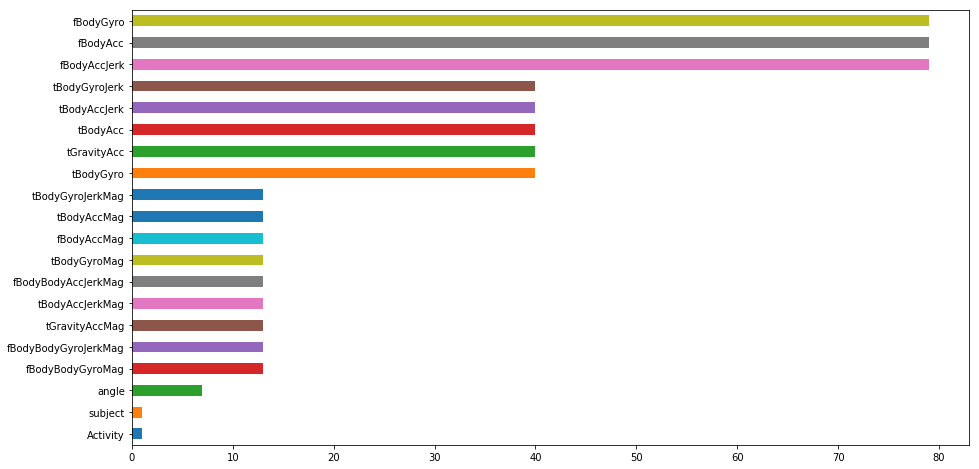

In [28]:
clean_colnames = [col.split('-')[0].split('(')[0] for col in har_data.columns]
pd.Series(clean_colnames).value_counts().sort_values().\
    plot(kind = 'barh', figsize=(15, 8))

#### PCA + TSNE

We will first examine the data using TSNE, by projecting the data into $\mathbb{R}^2$.

In [29]:
# remove subject, activity
subject, activity = har_data.subject, har_data.Activity
har_data.drop(columns=['subject', 'Activity'], inplace = True)

In [ ]:
tsne_data = har_data.sample(frac=.1).copy()
pca = PCA(n_components=0.9, random_state=3)
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)
tsne_data = pca.fit_transform(tsne_data)
tsne = TSNE(random_state=3, perplexity=40)
tsne_data = tsne.fit_transform(tsne_data)

In [18]:
# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(18,10))

### Plot Activities
# Get colors
n = activity.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

label_counts = activity.value_counts()

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (activity==group).values
    axarr[0].scatter(x=tsne_data[mask][:,0], y=tsne_data[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject.unique()):
    # Mask to separate sets
    mask = (subject==group).values
    axarr[1].scatter(x=tsne_data[mask][:,0], y=tsne_data[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

Nice! we can see a preaty good seperation in the upper plot. The lower plot seems more blurry, but we can still see some "islands" of color, meaning that different perticipant tend to perform some activities quite differently than others.

### VI Ordering

[Top](#MFML---Final-Project)

For each model and for each replication we will use the first $k$ best features to construct a model.

We will use 2 datasets:

1. Original dataset.
1. Using PCA + TSNE to produce 100 dimensional dataset.

We will compare the following models (and already implimanted VI):

1. RF
1. XGBoost
1. Wavelet-based RF
1. RF+SHAP
1. XGBoost+SHAP
1. Permutation

**SHAP (SHapley Additive exPlanations)** is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations. While SHAP values can explain the output of any machine learning model, the authers have developed a high-speed exact algorithm for tree ensemble methods ([paper](#https://arxiv.org/pdf/1802.03888.pdf)). 

We will use the `sklearn.model_selection.GridSearchCV` function (with 5-fold CV) for hyper-parameter tunning.

In [30]:
# our 5-fold generator
kcv = KFold(n_splits=5, random_state=3, shuffle=True)
# number of trees for all models
NTREE = 100
# ks - number of most imp features
ks = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 100]

#### Original Data

In [31]:
X = har_data.copy()
y = activity.copy()

##### Random Forest

We start with a simple RF model. We use grid search with 5-fold CV to select proper parameters.

In [32]:
rf_clf = GridSearchCV(RandomForestClassifier(n_estimators = NTREE, n_jobs = -1), 
                   param_grid = {'max_leaf_nodes':[100, 200, 300], 
                                 'min_samples_split' : [.001, .005, .01], 
                                 'max_features' : ['log2', 'sqrt']},
                  cv = 5, verbose = 1)
rf_clf_grid_search = rf_clf.fit(X, y)
print(rf_clf_grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  3.0min finished


{'min_samples_split': 0.001, 'max_leaf_nodes': 300, 'max_features': 'log2'}


Let us examine the RF model's (trained using best selected parameters) feature importance:

Find variable importance:

1. Compute importance of each feature and for each fold.
1. Average over 1 to compute the final feature importance.

In [33]:
vi_rf_clf_df = compute_vi(rf_clf_grid_search.best_estimator_, X.values, y.values, X.columns, kcv)

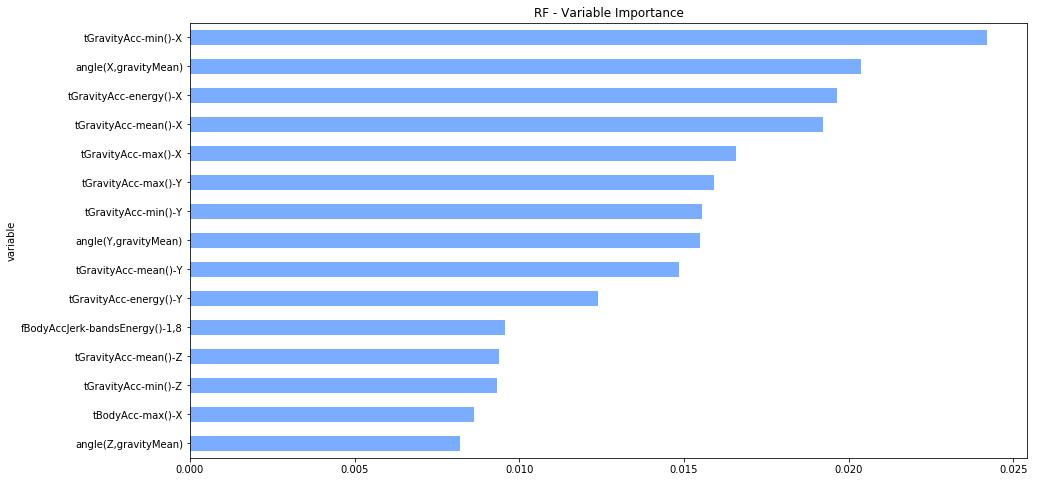

In [34]:
rf_clf_vi = vi_rf_clf_df.groupby('variable').imp.mean()
plt.figure(figsize=(15, 8))
rf_clf_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("RF - Variable Importance")
plt.show()

We use the selected parameters to fit a model and compute variable importance.

In [35]:
# sorted variables - according to our RF model
sorted_rf_clf_vars = rf_clf_vi.sort_values(ascending = False).index.tolist()

##### Random Forest with SHAP

In [36]:
shap.initjs()

In [39]:
explainer = shap.TreeExplainer(rf_clf_grid_search.best_estimator_)
shap_values = explainer.shap_values(X)

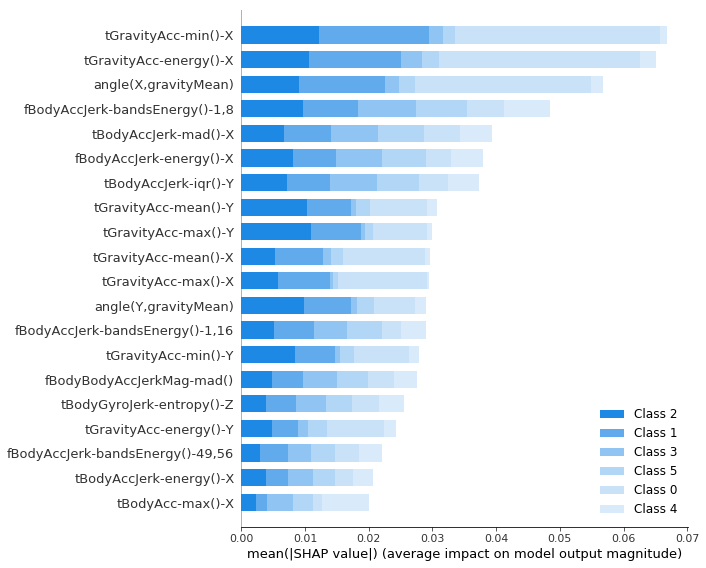

In [40]:
shap.summary_plot(shap_values, X, plot_type = 'bar')

In [41]:
vi_shap_df = compute_shap_vi(rf_clf_grid_search.best_estimator_, X.values, y.values, X.columns, kcv)

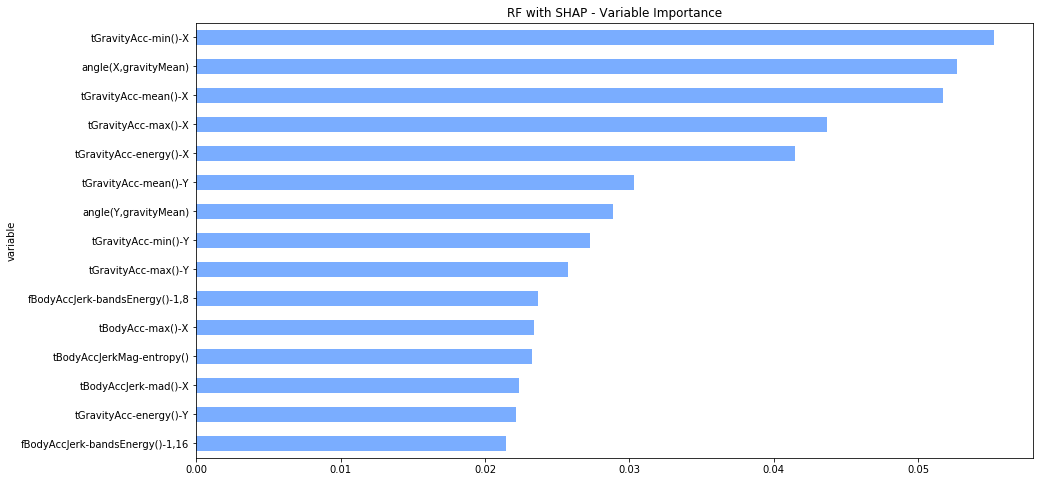

In [42]:
rf_shap_vi = vi_shap_df.groupby('variable').imp_sum.mean()
plt.figure(figsize=(15, 8))
rf_shap_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("RF with SHAP - Variable Importance")
plt.show()

In [43]:
sorted_rf_shap_vars = rf_shap_vi.sort_values(ascending = False).index.tolist()

#### XGBoost

In [167]:
params = {
#         'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.8, 1.0],
        'max_depth': [5, 9],
        'learning_rate':[.001, .01]
        }
xgb = XGBClassifier(n_estimators = NTREE)

In [168]:
grid_xgb = GridSearchCV(xgb, 
                        param_grid = params,
                        cv = 5, verbose = 1, n_jobs = -1)
xgb_grid_search = grid_xgb.fit(X, y)
print(xgb_grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 41.6min finished


{'learning_rate': 0.01, 'subsample': 0.75, 'max_depth': 9}


In [169]:
vi_xgb_df = compute_vi(xgb_grid_search.best_estimator_, X.values, y.values, X.columns, kcv)

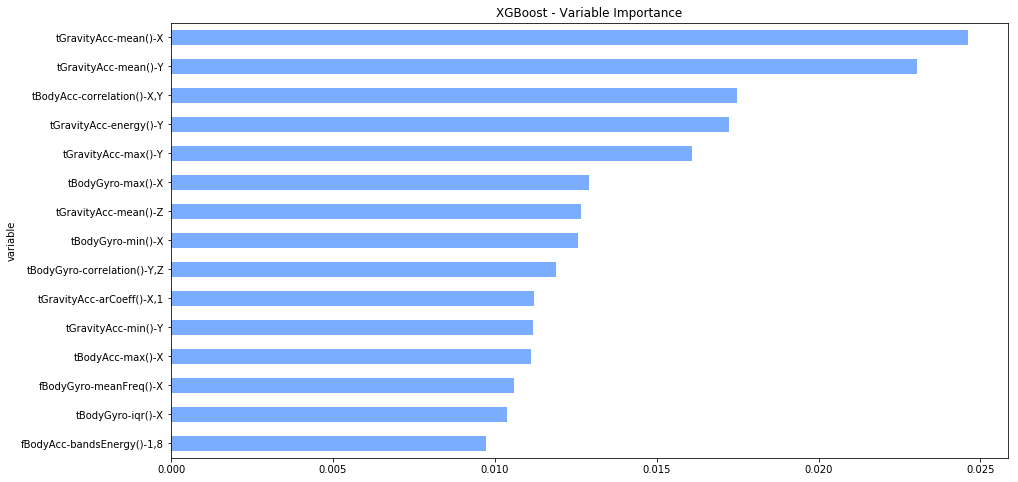

In [170]:
xgb_vi = vi_xgb_df.groupby('variable').imp.mean()
plt.figure(figsize=(15, 8))
xgb_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("XGBoost - Variable Importance")
plt.show()

In [171]:
sorted_xgb_vars = xgb_vi.sort_values(ascending = False).index.tolist()

##### XGBoost with SHAP

In [175]:
vi_shap_xgb_df = compute_shap_vi(xgb_grid_search.best_estimator_, X.values, y.values, X.columns, kcv)

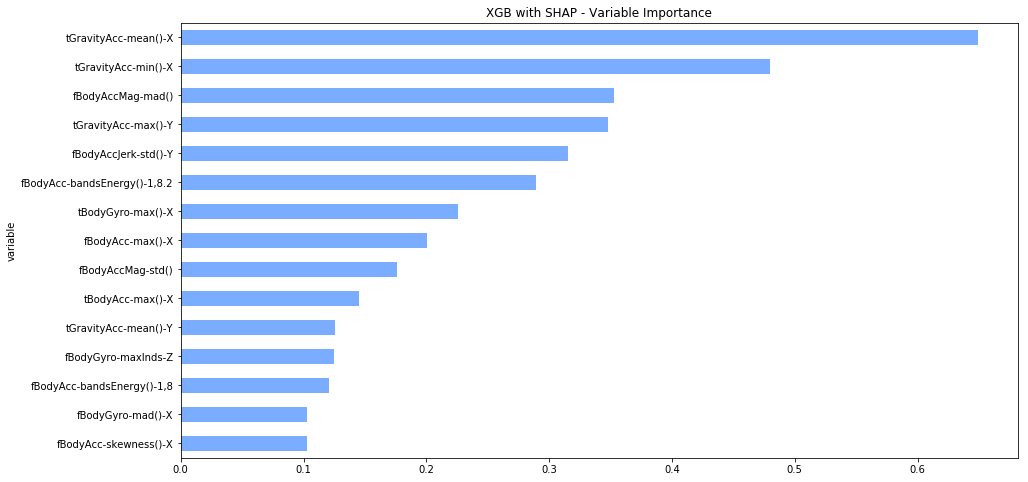

In [176]:
xgb_shap_vi = vi_shap_xgb_df.groupby('variable').imp_sum.mean()
plt.figure(figsize=(15, 8))
xgb_shap_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("XGB with SHAP - Variable Importance")
plt.show()

In [177]:
sorted_xgb_shap_vars = xgb_shap_vi.sort_values(ascending = False).index.tolist()

##### Skater

[Top](#MFML---Final-Project)


Skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature. The intuition is that the more a model’s decision criteria depend on a feature, the more we’ll see predictions change as a function of perturbing a feature.

In [44]:
interpreter = Interpretation(X, feature_names=X.columns)
model = InMemoryModel(rf_clf_grid_search.best_estimator_.predict_proba, examples=X)

In [45]:
interpreter = Interpretation()
interpreter.load_data(X)
perm_feature_importance = interpreter.feature_importance.feature_importance(model)

[561/561] features ████████████████████ Time elapsed: 533 seconds

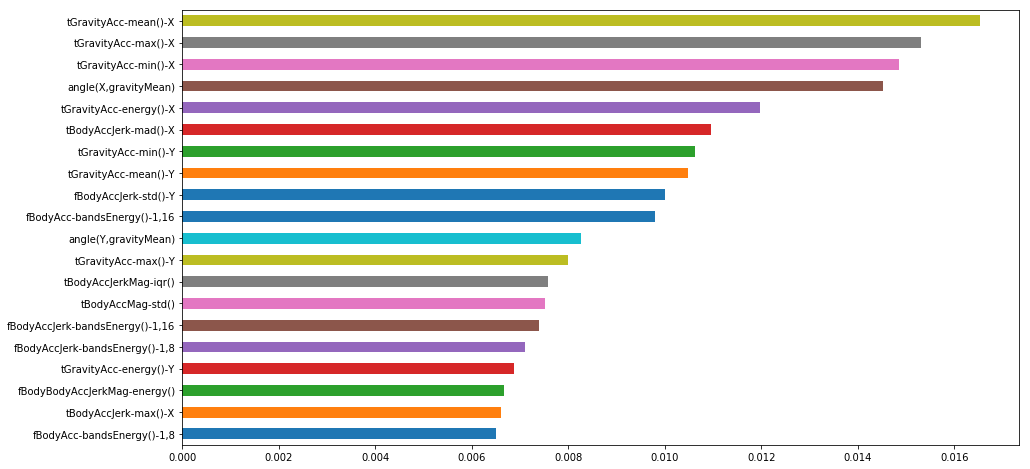

In [46]:
plt.figure(figsize=(15, 8))
perm_feature_importance.sort_values(ascending=True).tail(20).plot(kind = 'barh')

In [47]:
sorted_perm_vars = perm_feature_importance.sort_values(ascending=False).index

### Compare Orderings

[Top](#MFML---Final-Project)


We train the same classifier in order to compare the orderings of deferent VI approaches.

In [48]:
model_order = {'rf':sorted_rf_clf_vars, 
               'rf_shap':sorted_rf_shap_vars, 
#                'xgb':sorted_xgb_vars, 
#                'xgb_shap':sorted_xgb_shap_vars,
               'perm':sorted_perm_vars,
#                'wv_rf':
              }

In [49]:
# scoring metrics
scoring = {'acc' : 'accuracy', 
           'recall':lambda cls, X, y : 
                         recall_score(y, cls.predict(X), average = 'micro'), 
           'precision':lambda cls, X, y : 
                    precision_score(y, cls.predict(X), average = 'micro')}

# compute vi score for all orderings
vi_score_rf_df = compare_orderings(rf_clf_grid_search.best_estimator_,model_order,X,y,kcv,
                                ks = ks,
                                scoring = scoring)

Calc. VI score for rf...
Calc. VI score for perm...
Calc. VI score for rf_shap...


In [50]:
vi_score_rf_df['test_err'] = 1 - vi_score_rf_df['test_acc']

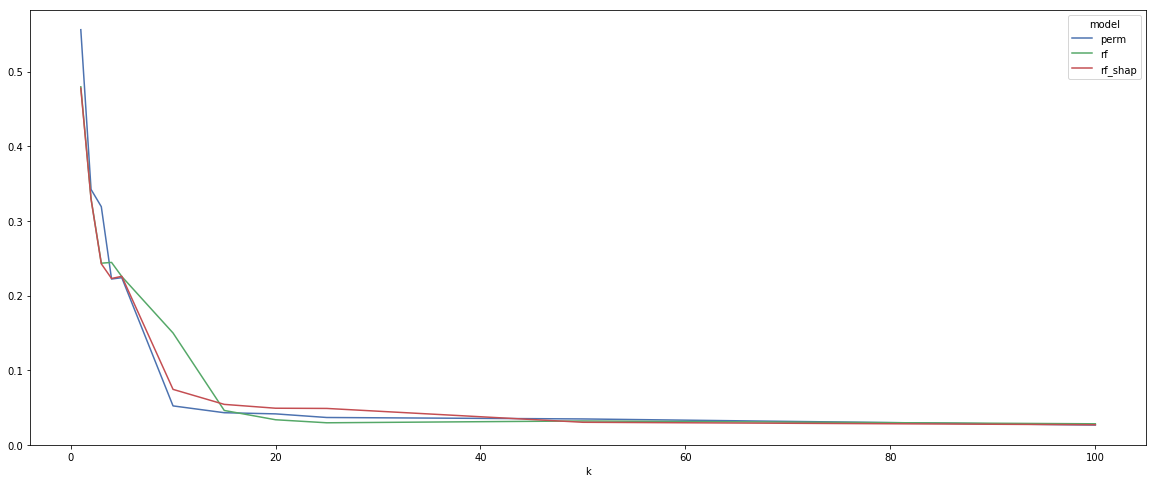

In [53]:
plt.style.use('seaborn-deep')
plot_vi(vi_score_rf_df, 'test_err')

In [54]:
# compute vi score for all orderings
vi_score_svm_df = compare_orderings(svm.SVC(decision_function_shape='ovo'),
                                    model_order,
                                    X, y, kcv,
                                    ks = ks,
                                    scoring = scoring)

Calc. VI score for rf...
Calc. VI score for perm...
Calc. VI score for rf_shap...


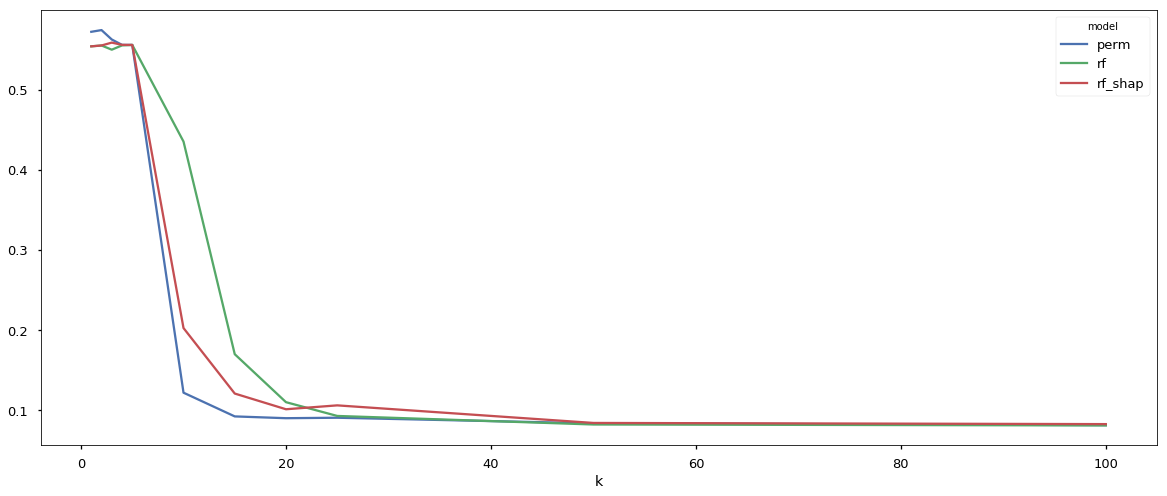

In [55]:
plt.style.use('seaborn-talk')
vi_score_svm_df['test_err'] = 1 - vi_score_svm_df['test_acc']
plot_vi(vi_score_svm_df, 'test_err')

## Regression - Abalone Age Prediction

[Top](#MFML---Final-Project)

### What's an Abalone

Abalones are marine snails. Their taxonomy puts them in the family Haliotidae which contains only one genus, Haliotis, which once contained six subgenera. These subgenera have become alternate representations of Haliotis. The number of species recognized worldwide ranges between 30 and 130 with over 230 species-level taxa described. The most comprehensive treatment of the family considers 56 species valid, with 18 additional subspecies.

Abalones can be found along coasts of almost every continent. Usually, abalones are consumed as food all around the world, by different cultures. However, the bright and variety of colors of the interior side of their shells makes then an valuable object of adornment and decoration.

The age of an abalone can be determined from the number of rings in their shell. However, counting the number of rings in an abalone shell is an expensive method. Thus, one possible solution is predict the number of rings of an abalone from characteristics like height, diameter, lenght and weight measurements.

The Abalone dataset consist of following attributes:

1. Sex
1. Length Longest shell measurement
1. Diameter perpendicular to length
1. Height with meat in shell
1. Whole weight whole abalone
1. Shucked weight weight of meat
1. Viscera weight gut weight (after bleeding)
1. Shell weight after being dried
1. Rings


### Load Data

[Top](#MFML---Final-Project)

In [136]:
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone_data = pd.read_csv(path, names=column_names)
print("Number of samples: %d" % len(abalone_data))
abalone_data.head()

Number of samples: 4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### EDA

[Top](#MFML---Final-Project)

In [ ]:
sns.pairplot(abalone_data, hue="sex")

In [ ]:
plt.figure(figsize = (15,8))
sns.distplot(abalone_data.rings, color="#7aadff", 
             hist=False, rug=False, kde_kws={"shade": True})

### VI Ordering

[Top](#MFML---Final-Project)

In [ ]:
# our 5-fold generator
kcv = KFold(n_splits=5, random_state=4, shuffle=True)
# number of trees for all models
NTREE = 500
# ks - number of most imp features
ks = range(1,11)

In [ ]:
X = har_data.copy()
y = activity.copy()

#### RF

In [ ]:
rf_reg_grid = GridSearchCV(RandomForestRegressor(n_estimators = NTREE, n_jobs = -1), 
                   param_grid = {'max_leaf_nodes':[100, 200, 300], 
                                 'min_samples_split' : [.001, .005, .01], 
                                 'max_features' : ['log2', 'sqrt']},
                  cv = 5, verbose = 1)

rf_reg_grid_search = rf_reg_grid.fit(X, y)
print(rf_reg_grid_search.best_params_)

In [ ]:
vi_rf_clf_df = compute_vi(rf_clf_grid_search.best_estimator_, X.values, y.values, X.columns, kcv)

In [ ]:
rf_reg_vi = rf_reg_vi_df.groupby('variable').imp.mean()
plt.figure(figsize=(15, 8))
rf_reg_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("RF - Variable Importance")
plt.show()

In [ ]:
# sorted variables - according to our RF model
rf_reg_sorted_vars = rf_reg_vi.sort_values(ascending = False).index.tolist()

### RF + SHAP

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(rf_reg_grid_search.best_estimator_)
shap_values = explainer.shap_values(X)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
X_sample = X.sample(2000, random_state = 1).copy()
shap.force_plot(explainer.expected_value, shap_values[X_sample.index.values], X_sample)

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [ ]:
rf_reg_vi_shap_df = compute_shap_vi(rf_reg_grid_search.best_estimator_, 
                                    X.values, y.values, X.columns, kcv, reg = True)

In [ ]:
rf_reg_vi = rf_reg_vi_shap_df.groupby('variable').imp_sum.mean()
plt.figure(figsize=(15, 8))
rf_reg_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("RF regression - Variable Importance")
plt.show()

In [ ]:
sorted_rf_reg_shap_vars = rf_reg_vi.sort_values(ascending = False).index.tolist()

#### XGBoost Regressor

In [ ]:
params = {
#         'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.7, 0.85, 1.0],
        'max_depth': [3, 5, 7],
        'learning_rate':[.001, .01, 0.1]
        }
xgb = XGBRegressor(n_estimators = NTREE)

In [ ]:
grid_xgb_reg = GridSearchCV(xgb, 
               param_grid = params,
               cv = 5, verbose = 1)

grid_xgb_reg = grid_xgb_reg.fit(X, y)
print(grid_xgb_reg.best_params_)

In [ ]:
vi_xgb_reg_df = compute_vi(grid_xgb_reg.best_estimator_, X.values, y.values, X.columns, kcv)

In [ ]:
xgb_vi = vi_xgb_reg_df.groupby('variable').imp.mean()
sorted_xgb_vars = xgb_vi.sort_values(ascending = False).index.tolist()

In [ ]:
plt.figure(figsize=(15, 8))
xgb_vi.nlargest(15).sort_values().plot(kind = "barh", color = "#7aadff")
plt.title("XGBoost regression - Variable Importance")
plt.show()

#### XGBoost + SHAP

### Compare Ordering

[Top](#MFML---Final-Project)